In [1]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
with open('/content/Book1.csv', encoding='utf-8', errors='replace') as f:
    data = pd.read_csv(f)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58384 entries, 0 to 58383
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Client Sender ID    58384 non-null  object 
 1   Destination number  58384 non-null  float64
 2   MCCMNC              58383 non-null  float64
 3   Country             58383 non-null  object 
 4   SMS text            58384 non-null  object 
 5   Case                58384 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 2.7+ MB


In [5]:
data.describe()

,Destination number,MCCMNC,Case
count,5.838400e+04,58383.000000,58384.000000
mean,2.274377e+11,509808.480106,0.269235
std,2.334747e+11,218984.894593,0.443566
min,6.452478e+07,208.000000,0.000000
25%,2.440000e+11,530003.000000,0.000000
50%,2.440000e+11,630086.000000,0.000000
75%,2.440000e+11,630089.000000,1.000000
max,5.600000e+12,732123.000000,1.000000


In [6]:
data.isna().sum()

Client Sender ID      0
Destination number    0
MCCMNC                1
Country               1
SMS text              0
Case                  0
dtype: int64

In [7]:
data= data.dropna()

In [8]:
dup= data.duplicated().sum()
print(dup)

5532


In [9]:
data= data.drop_duplicates()

In [10]:
data['content']= data['SMS text']+' '+data['Client Sender ID']+' '+data['Country']
fraud_words = ''
normal_words = ''
common_stopwords = set(STOPWORDS)

for val in data[data['Case']==1].content:
    tokens = val.split()
    lowercase_words= [token.lower() for token in tokens]

    processed_text = " ".join(lowercase_words)
    fraud_words += processed_text + " "

for text in data[data['Case']==0].content:
    tokens = val.split()
    lowercase_words= [token.lower() for token in tokens]

    processed_textt = " ".join(lowercase_words)
    normal_words += processed_textt + " "

<ipython-input-10-3f7c58584e57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['content']= data['SMS text']+' '+data['Client Sender ID']+' '+data['Country']


In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(normal_words)

plt.figure(figsize = (6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(fraud_words)

plt.figure(figsize = (6, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [13]:
stop_words = stopwords.words('english')

In [14]:
lemmatizer=WordNetLemmatizer()
for index, row in data.iterrows():
    updated_text = ''

    cleaned_text = row['content']
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

    word_tokens = nltk.word_tokenize(cleaned_text)

    word_tokens = [word for word in word_tokens if not word in stop_words]

    for word in word_tokens:
        updated_text += ' ' + str(lemmatizer.lemmatize(word)).lower()

    updated_text= data.loc[index, 'content']

In [15]:
data = data[['content','Case']]
X_train = data['content']
Y_train = data['Case']

In [16]:
def vectorized_text(features, max_features):
  vectorizer= TfidfVectorizer(stop_words='english', decode_error='strict', analyzer='word',
                              ngram_range=(1,2), max_features=max_features)
  featured_vect= vectorizer.fit_transform(features)
  return featured_vect.toarray()

In [17]:
count_vectorizer= CountVectorizer()
count_vectorizer.fit_transform(X_train)
fmatrix= count_vectorizer.transform(X_train)
tf_idf= TfidfTransformer(norm="l2")
tf_idf.fit(fmatrix)
tfidf_matrix= tf_idf.fit_transform(fmatrix)
tfidf_matrix

<52851x42189 sparse matrix of type '<class 'numpy.float64'>'
	with 636536 stored elements in Compressed Sparse Row format>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, Y_train, test_size= 0.2, random_state=42)

In [19]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred_lr))

Accuracy: 0.9996216062813358


In [20]:
print('Accuracy of Logistic Regression on training data: {:.2f}'.format(lr.score(X_train, y_train)))
print('Accuracy of Logistic Regression on testing data: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of Logistic Regression on training data: 1.00
Accuracy of Logistic Regression on testing data: 1.00


In [21]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8095
           1       1.00      1.00      1.00      2476

    accuracy                           1.00     10571
   macro avg       1.00      1.00      1.00     10571
weighted avg       1.00      1.00      1.00     10571



In [ ]:
cm_lr= confusion_matrix(y_test, pred_lr)
print(cm_lr)
plt.figure(figsize=(5,5))
sns.heatmap(cm_lr, annot=True, cmap= 'plasma', fmt= 'd')
plt.title('Confusion Matrix LR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Support Vector Classifier

In [ ]:
svc= SVC(kernel= 'linear', C=0.001)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(accuracy_score(y_test, y_pred_svc))

In [24]:
print('Accuracy of Support Vector Classifier on training data: {:.2f}'.format(svc.score(X_train, y_train)))
print('Accuracy of Support Vector Classifier on testing data: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of Support Vector Classifier on training data: 0.96
Accuracy of Support Vector Classifier on testing data: 0.95


Classification Report for Support Vector Classifier

In [25]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8095
           1       1.00      0.80      0.89      2476

    accuracy                           0.95     10571
   macro avg       0.97      0.90      0.93     10571
weighted avg       0.96      0.95      0.95     10571



Confusion Matrix for Support Vector Classifier

[[8095    0]
 [ 502 1974]]


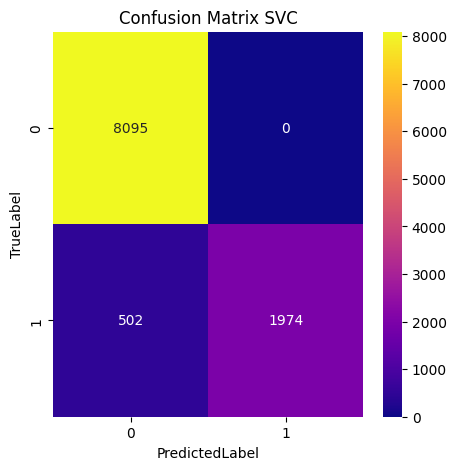

In [26]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
print(cm_svc)
plt.figure(figsize = (5, 5))
sns.heatmap(cm_svc, annot = True, cmap ='plasma', fmt ='d')
plt.title('Confusion Matrix SVC')
plt.xlabel('PredictedLabel')
plt.ylabel('TrueLabel')
plt.show()